In [1]:
! nvidia-smi

Mon Nov 22 19:03:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install fastai --upgrade

     |████████████████████████████████| 189 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
import fastai
from fastai.vision.all import *
import numpy as np

In [4]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

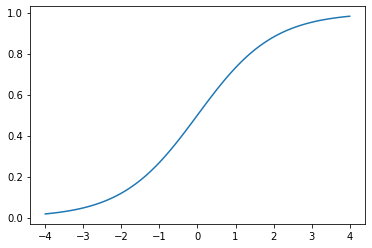

In [ ]:
plot_function(torch.sigmoid, min = -4, max = 4)

In [ ]:
path = untar_data(URLs.PASCAL_2007)

In [ ]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.csv')]

In [ ]:
df = pd.read_csv(path/"train.csv")

In [ ]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
dblock = DataBlock()

In [ ]:
dsets = dblock.datasets(df)

In [ ]:
dsets.train[0]

(fname           004140.jpg
 labels      bicycle bottle
 is_valid             False
 Name: 2083, dtype: object, fname           004140.jpg
 labels      bicycle bottle
 is_valid             False
 Name: 2083, dtype: object)

In [ ]:
dsets.valid[0]

(fname                 004164.jpg
 labels      chair tvmonitor sofa
 is_valid                   False
 Name: 2095, dtype: object, fname                 004164.jpg
 labels      chair tvmonitor sofa
 is_valid                   False
 Name: 2095, dtype: object)

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('000224.jpg', 'tvmonitor bottle')

In [ ]:
def get_x(r): 
  return path/'train'/r['fname']


def get_y(r):
  return r['labels'].split(' ')


dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/001385.jpg'), ['bus', 'car'])

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=436x500,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         0., 1.]))

In [ ]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#3) ['person','sofa','tvmonitor']

In [ ]:
idxs

TensorMultiCategory([14, 17, 19])

In [ ]:
len(dsets.train[0][1])

20

In [ ]:
def splitter(df):
  train = df.index[~df["is_valid"]].tolist()
  valid = df.index[df["is_valid"]].tolist()

  return train,valid

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   splitter = splitter, 
                   get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), 
                   splitter = splitter,
                   get_x = get_x, get_y = get_y, 
                   item_tfms = RandomResizedCrop(128, min_scale = 0.35))

dls = dblock.dataloaders(df)

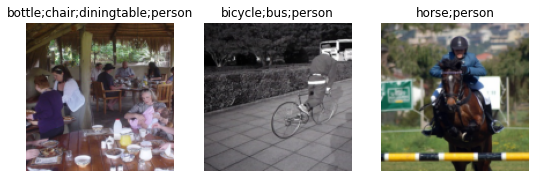

In [ ]:
dls.show_batch(nrows = 1, ncols = 3)

In [ ]:
learn = cnn_learner(dls, resnet18)

In [ ]:
learn.model = learn.model.to(device = "cuda")

In [ ]:
x,y = dls.train.one_batch()
x = x.to("cuda")
activs = learn.model(x)

print (activs.shape)

torch.Size([64, 20])


In [ ]:
activs[0].shape

torch.Size([20])

In [ ]:
activs[0]

TensorBase([ 0.4517, -0.4970,  0.6752,  1.9092,  0.9403,  1.4564, -1.0941,  2.2055,
         1.0393, -1.2664,  4.0366, -1.2245,  1.0895, -0.6539, -1.5961,  1.9073,
         2.9986, -0.5290, -0.9335,  1.2233], device='cuda:0',
       grad_fn=<AliasBackward0>)

In [ ]:
activs[0].sigmoid()

TensorBase([0.6110, 0.3782, 0.6627, 0.8709, 0.7192, 0.8110, 0.2508, 0.9007, 0.7387,
        0.2199, 0.9826, 0.2272, 0.7483, 0.3421, 0.1685, 0.8707, 0.9525, 0.3707,
        0.2822, 0.7726], device='cuda:0', grad_fn=<AliasBackward0>)

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
print (loss)

TensorMultiCategory(1.0565, device='cuda:0', grad_fn=<AliasBackward0>)


In [ ]:
def accuracy_multi(inp, targ, thresh = 0.5, sigmoid = True):
  if sigmoid :
    inp = inp.sigmoid()
  return ((inp>thresh) == targ.bool()).float().mean()

In [ ]:
### partial function in python

def hello(inp, say_what = "hello"):
  return f"{say_what} {inp}"

In [ ]:
hello("sadiva")

'hello sadiva'

In [ ]:
f = partial(hello, say_what = "namaste")

In [ ]:
f("jeremy")

'namaste jeremy'

In [ ]:
learn = cnn_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh = 0.2))
learn.fine_tune(3, base_lr = 3e-3, freeze_epochs = 4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.939239,0.678883,0.239900,00:41
1,0.820331,0.557196,0.289861,00:38
2,0.601778,0.199717,0.827032,00:38
3,0.362014,0.128188,0.938187,00:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134434,0.113988,0.949044,00:43
1,0.117584,0.105934,0.950996,00:41
2,0.098952,0.103378,0.951454,00:41


In [ ]:
learn.metrics = partial(accuracy_multi, thresh = 0.1)
learn.validate()

(#2) [0.10337752848863602,0.9314143657684326]

In [ ]:
learn.metrics = partial(accuracy_multi, thresh = 0.9)
learn.validate()

(#2) [0.10337752848863602,0.9575697183609009]

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh = 0.9, sigmoid = False)

TensorMultiCategory(0.9576)

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)

In [ ]:
xs

tensor([0.0500, 0.0821, 0.1143, 0.1464, 0.1786, 0.2107, 0.2429, 0.2750, 0.3071,
        0.3393, 0.3714, 0.4036, 0.4357, 0.4679, 0.5000, 0.5321, 0.5643, 0.5964,
        0.6286, 0.6607, 0.6929, 0.7250, 0.7571, 0.7893, 0.8214, 0.8536, 0.8857,
        0.9179, 0.9500])

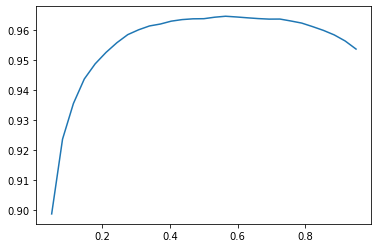

In [ ]:
accs = [accuracy_multi(preds, targs, thresh = i, sigmoid = False) for i in xs]
plt.plot(xs, accs)

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/09'),Path('/root/.fastai/data/biwi_head_pose/16'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/15.obj'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/05.obj'),Path('/root/.fastai/data/biwi_head_pose/24.obj'),Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/19.obj')...]

In [7]:
(path/"01").ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00264_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00417_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00071_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00213_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00412_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00069_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00328_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00365_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00434_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00476_rgb.jpg')...]

In [8]:
img_files = get_image_files(path)

def img2pose(x):
  return Path(f"{str(x)[:-7]}pose.txt")

img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/09/frame_00701_pose.txt')

(480, 640)


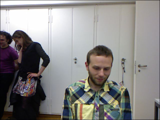

In [9]:
im = PILImage.create(img_files[0])
print (im.shape)

im.to_thumb(160)

In [10]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header = 3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]

  return tensor([c1, c2])

In [11]:
get_ctr(img_files[0])

tensor([406.1625, 276.5646])

In [12]:
biwi = DataBlock(blocks = (ImageBlock, PointBlock), 
                 get_items = get_image_files, 
                 get_y = get_ctr,
                 splitter = FuncSplitter(lambda o : o.parent.name == '13'),
                 batch_tfms = [*aug_transforms(size = (240,320)), 
                               Normalize.from_stats(*imagenet_stats)])

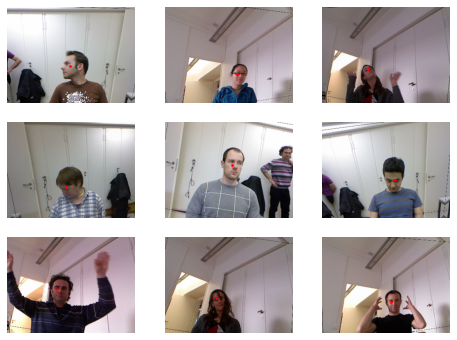

In [23]:
dls = biwi.dataloaders(path, device = "cuda")
dls.show_batch(max_n = 9, figsize = (8,6))

In [14]:
xb, yb = dls.one_batch()

print (xb.shape, yb.shape)

torch.Size([64, 3, 240, 320]) torch.Size([64, 1, 2])


In [15]:
yb[0]

TensorPoint([[0.1016, 0.0365]], device='cuda:0')

In [24]:
## we are passing y_range to tell the cnn_learner the range of our outputs. In pytorch and fastai coordinates are always scaled between -1 to 1.
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

In [25]:
# y_range is implemented using sigmoid range

def sigmoid_range(x, lo, hi) :
  return torch.sigmoid(x) * (hi - lo) + lo

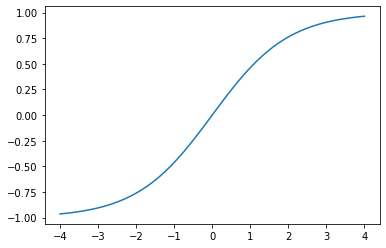

In [26]:
plot_function(partial(sigmoid_range, lo = -1, hi = 1), min = -4, max = 4)

In [27]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0012022644514217973)

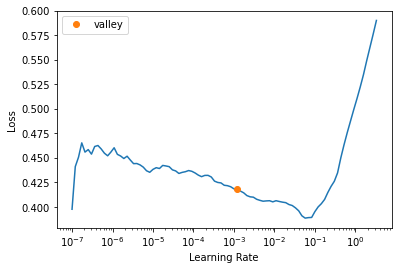

In [28]:
learn.lr_find()

In [29]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.049134,0.031009,02:45
1,0.006769,0.001529,02:45
2,0.003108,0.000421,02:44
3,0.002061,0.000336,02:46
4,0.001493,0.000149,02:46


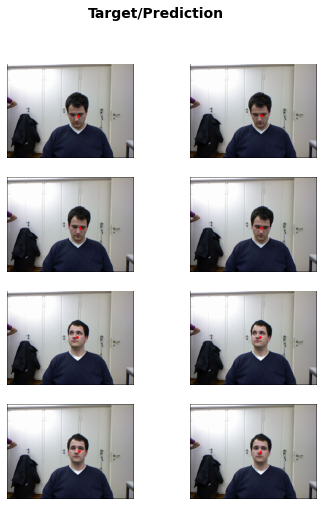

In [30]:
learn.show_results(ds_idx = 1, max_n = 4, figsize = (6,8))

In [31]:
learn = cnn_learner(dls, resnet18, loss_func = nn.L1Loss(), y_range = (-1, 1))

In [32]:
learn.fine_tune(2, base_lr = 0.002)

epoch,train_loss,valid_loss,time
0,0.331316,0.087549,02:49


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: Using a target size (torch.Size([64, 1, 2])) that is different to the input size (torch.Size([64, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: Using a target size (torch.Size([37, 1, 2])) that is different to the input size (torch.Size([37, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,time
0,0.154700,0.092499,03:09
1,0.151671,0.103820,03:07


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: Using a target size (torch.Size([64, 1, 2])) that is different to the input size (torch.Size([64, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


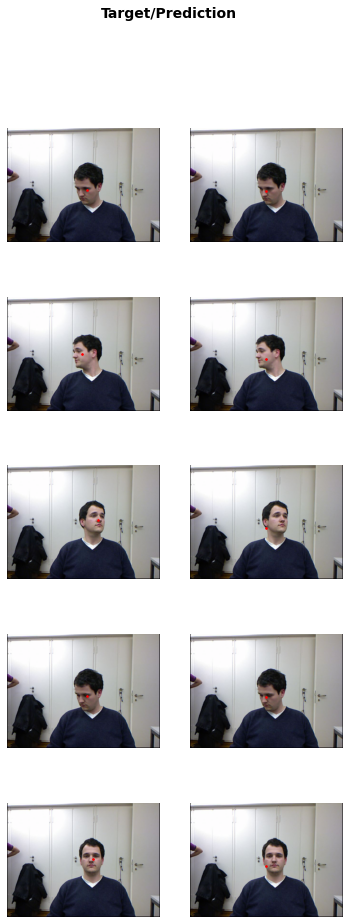

In [33]:
learn.show_results(ds_idx = 1, max_n = 5)